# Introduction to Sentinel 2

**What does this notebook do?** This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on `cloud` and `cloud shadow`-free pixels. 

**Before you run this notebook:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

`module use /g/data/v10/public/modules/modulefiles`

`module load dea`

**Date**: November 2018

**Author**: Claire Krause, Robbi Bishop-Taylor

In [1]:
%matplotlib inline
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../10_Scripts'))
import DEAPlotting
import DEADataHandling

# Connect to datacube
dc = Datacube(app='Intro to Sentinel2')

## Sentinel 2 products currently available

In [2]:
products = dc.list_products()
display_columns = ['name', 'description', 'instrument',
                   'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

,name,description,instrument,platform,product_type,crs,resolution
id,,,,,,,
90,s2a_ard_granule,Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2A,S2MSIARD,NaN,NaN
92,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,NaN,NaN
91,s2b_ard_granule,Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2B,S2MSIARD,NaN,NaN
93,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,NaN,NaN


There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

## Loading Sentinel 2 data

We will focus on data from the Sentinel-2a platform for this demonstration, as there is more data available than 2b. To explore the spectral datasets from Sentinel-2a, we will use the `s2a_ard_granule` product. Sometimes multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this.

To load in the Sentinel data, we have a number of options we can use in building our data extraction query:

* `lat`/`lon` - specify a bounding box for the extraction. Note that a polygon can be used instead. See [here](https://datacube-core.readthedocs.io/en/stable/dev/generate/datacube.api.query.Query.html#datacube.api.query.Query) for more details
* `output_crs` - the output coordinate reference system to project the data into. The CRS you request will impact on the format for the `resolution` query. Two handy CRSs are 'EPSG:3577', which is the Australian Albers projected coordinate system, and 'EPSG:4325', which is WGS84 a global geographic coordinate system.
* `resolution` - the requested output resolution for the data. If you have selected a geographic coordinate system for the `output_crs`, this will be in degrees. If you have selected a projected coordinate system, this will be in metres. 
* `time` - the time range for the query.

In [3]:
query = {
        'lat': (-35.27, -35.33),
        'lon': (149.07, 149.15),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time': ('2017-01-01', '2017-02-01')
        }

Canberra = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

### See what came back from the extraction

In [4]:
Canberra

<xarray.Dataset>
Dimensions:                (time: 2, x: 405, y: 380)
Coordinates:
  * time                   (time) datetime64[ns] 2017-01-05T00:02:12.026000 2017-01-15T00:02:11.026000
  * y                      (y) float64 -3.956e+06 -3.956e+06 ... -3.963e+06
  * x                      (x) float64 1.544e+06 1.544e+06 ... 1.553e+06
Data variables:
    azimuthal_exiting      (time, y, x) float32 24.900135 ... 127.58696
    azimuthal_incident     (time, y, x) float32 23.90676 39.06566 ... 149.86623
    exiting                (time, y, x) float32 10.388568 13.48787 ... 2.201671
    incident               (time, y, x) float32 36.450188 ... 30.279655
    relative_azimuth       (time, y, x) float32 26.755356 ... 28.386116
    relative_slope         (time, y, x) float32 -0.9933758 ... 22.279266
    satellite_azimuth      (time, y, x) float32 100.571175 ... 100.57671
    satellite_view         (time, y, x) float32 4.7305017 4.72948 ... 4.0362
    solar_azimuth          (time, y, x) float32 73

### Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

**Note** There are a number of additional datasets that are alse returned from our query. These are a combination of datasets used in the correction process, and layers relating to pixel quality. We will explore the pixel quality layers below.

### Data corrections

There are two corrections applied to the Sentinel data:

1. **NBAR (e.g. `nbar_green`)**  
NBAR stands for Nadir-corrected BRDF Adjusted Reflectance, where BRDF stands for Bidirectional reflectance distribution function The approach involves atmospheric correction to compute surface-leaving radiance, and bi-directional reflectance modelling to remove the effects of topography and angular variation in reflectance.

2. **T_NBAR (e.g. `nbart_green`)**  
Surface reflectance T_NBAR includes the terrain illumination reflectance correction and has the same features of NBAR, along with some additional features.

For more information on these corrections, see the explanation on the [DEA surface reflectance page](http://geoscienceaustralia.github.io/digitalearthau/data/data.html#). 

### Dealing with missing data

Note that the `nbart` data insert a missing value (`-9999`) into the dataset to denote a terrain shadow. This should be converted to a `NaN` value before using this data to avoid treating it as a valid value:



In [5]:
Canberra = masking.mask_invalid_data(Canberra)

### Plot as a true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

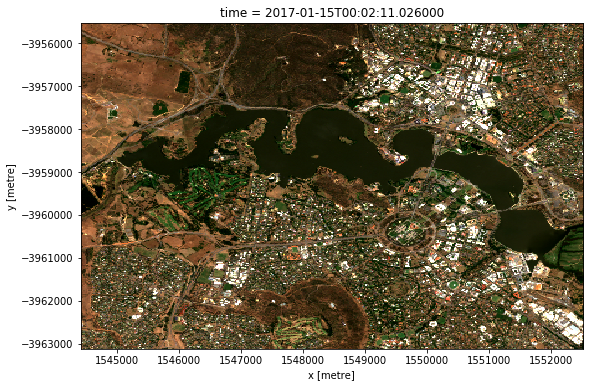

In [6]:
DEAPlotting.rgb(Canberra, bands=['nbart_red', 'nbart_green', 'nbart_blue'], index=1)

### Plot as a false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

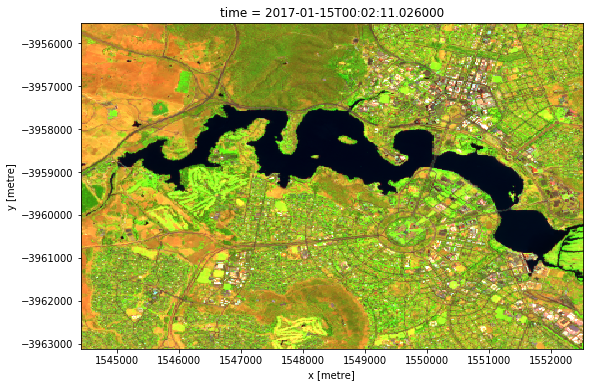

In [7]:
DEAPlotting.rgb(Canberra, bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], index=1)

### Compare observations side-by-side

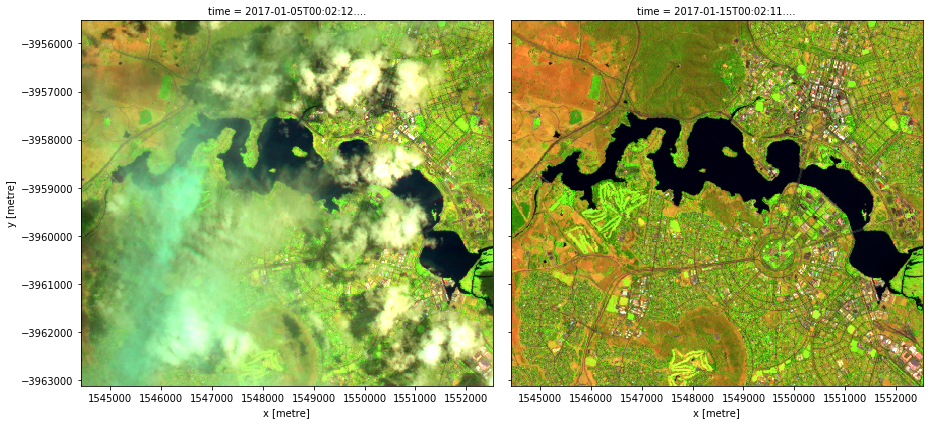

In [17]:
# Select multiple images to plot by giving a list of values to `index`.
# This example plots the first and the second image in the dataset:
DEAPlotting.rgb(Canberra, bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], index=[0, 1])

## Filter scenes using pixel quality

A pixel quality dataset (`fmask`) is provided alongside the spectral data, which can be used to filter out noisy pixels. The key things we want to filter are clouds and shadows. 

The `fmask` field contains values from 0 to 5. 

| Value | Description |
|-------|-------------|
| 0 | Null |
| 1 | Valid |
| 2 | Cloud |
| 3 | Cloud shadow |
| 4 | Snow |
| 5 | Water |

Here is the cloudy image we would like to mask:

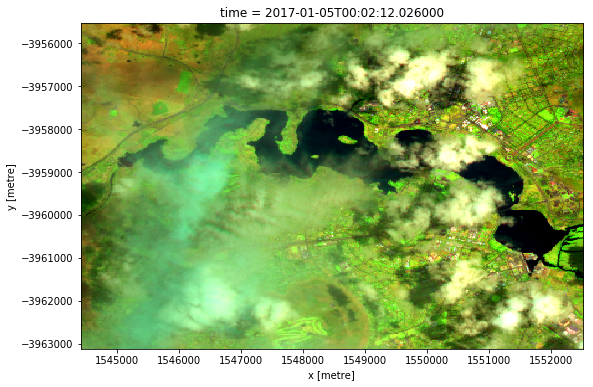

In [9]:
DEAPlotting.rgb(Canberra, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'], index=0)

### Plot pixel quality information 
Here we plot pixel quality information that corresponds to the observation above. This data is stored in the `fmask` variable:

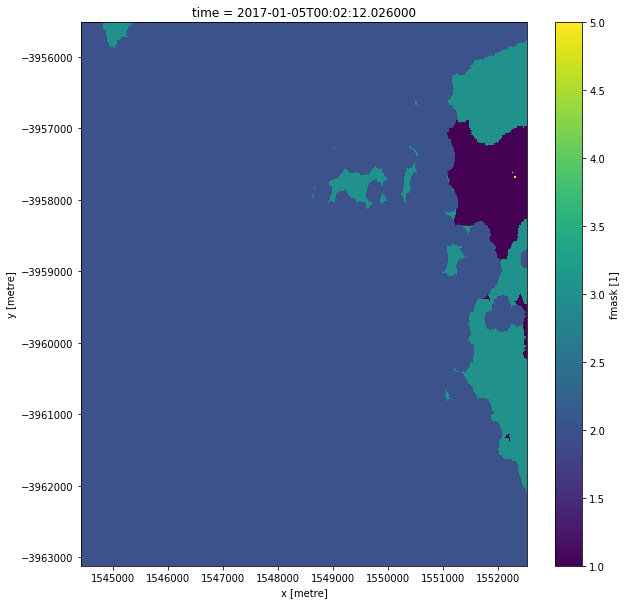

In [10]:
Canberra.isel(time=0).fmask.plot(figsize=[10, 10])

### Use pixel quality information to create a mask, and apply it to the spectral data

We want to filter out no data, cloud and cloud shadow, so we will use the `fmask` values `0`, `2` and `3` for our filter.

In [11]:
# Numpy's `isin` function tests whether a pixel's value is in `test_elements`. Because we want to 
# discard pixels where this is the case (because these pixels represent nodata, cloud or cloud shadow),
# we also use `invert=True` to keep only good quality pixels
clear_pixels = np.isin(Canberra.fmask, test_elements=[0, 2, 3], invert=True)

# Use clear pixels as a mask to keep only clear pixels
Clear_Canberra = Canberra.where(clear_pixels)

### Plot cloud-masked image

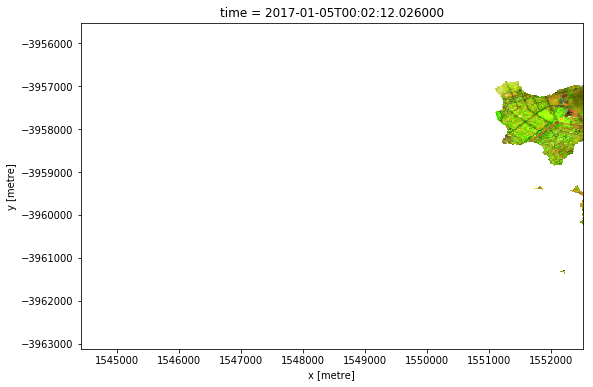

In [12]:
DEAPlotting.rgb(Clear_Canberra, bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], index=0)

## Use `load_clearsentinel2` to automatically load cloud free observations
To make loading Sentinel 2 data more convenient, the `load_clearsentinel2` function was written to automate common tasks like returning cloud-free time series:

In [13]:
query = {
        'lat': (-35.27, -35.33),
        'lon': (149.07, 149.15),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time': ('2017-01-01', '2017-02-01')
        }

# The `load_clearsentinel2` can be given a query containing spatial and temporal bounds, and a list of bands to return.
# By setting `mask_pixel_quality=True`, the function will automatically remove nodata, cloud or cloud shadow pixels:
Clear_Canberra = DEADataHandling.load_clearsentinel2(dc=dc,
                                                     query=query,
                                                     bands_of_interest=('nbart_red', 'nbart_green', 'nbart_blue', 
                                                                        'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'),
                                                     masked_prop=0,
                                                     mask_pixel_quality=True)

Loading s2a pixel quality
    Loading 2 filtered s2a timesteps
Loading s2b pixel quality
    Skipping s2b; no valid data for query
Combining and sorting s2a data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


We can plot the same observation as earlier to verify we get the same result:

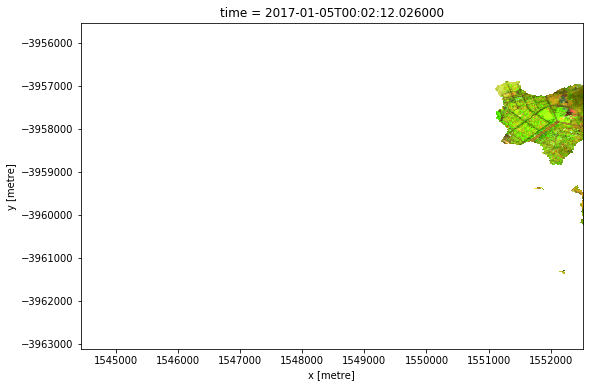

In [14]:
DEAPlotting.rgb(Clear_Canberra, bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], index=0)

### Returning only cloud-free images
The `load_clearsentinel2` function also allows you to return only images that contain greater than a given percentage of good quality pixels. For example, this can be used to return only cloud-free images. To do this, we specify a minimum proportion of good pixels using the `masked_prop` argument (e.g. specifying 0.3 below will return only images with more than 30% good quality, cloud-free pixels).

**Please note:** the Sentinel 2 cloud masking algorithm currently performs poorly over urban areas, where it commonly confuses buildings with clouds. Because of this, you make need to use a small value for `masked_prop` to ensure the algorithm does not discard an excessive number of images.

In [15]:
Clear_Canberra = DEADataHandling.load_clearsentinel2(dc=dc,
                                                     query=query,
                                                     bands_of_interest=('nbart_red', 'nbart_green', 'nbart_blue', 
                                                                        'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'),
                                                     masked_prop=0.3)

Loading s2a pixel quality
    Loading 1 filtered s2a timesteps
Loading s2b pixel quality
    Skipping s2b; no valid data for query
Combining and sorting s2a data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


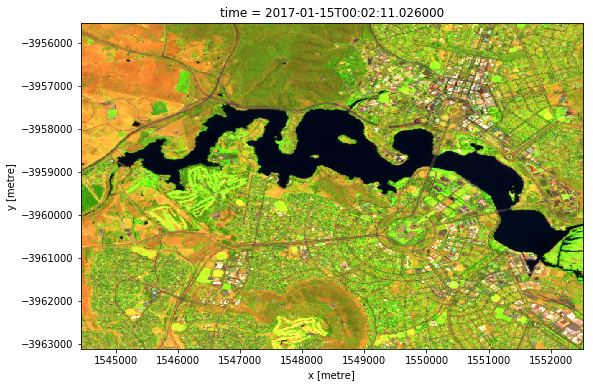

In [16]:
DEAPlotting.rgb(Clear_Canberra, bands=['nbart_swir_2', 'nbart_nir_1', 'nbart_green'], index=0)